# <span style="color:darkblue">02-Spot_detection</span>

In this notebook we will guide you through performing spot detection using the BigFISH libray, opening your images in Napari, and saving the generated spot detection data. For more documentation of the BigFISH library see: https://big-fish.readthedocs.io/en/stable/index.html. At the end of this notebook batch spot detection can be performed.

## 2.0 - Load libraries

In [1]:
import numpy as np
from glob import glob
from pathlib import Path
import re
from skimage import io
import matplotlib.pyplot as plt
from bigfish.detection import detect_spots
from bigfish.stack import remove_background_gaussian
from bigfish.stack import get_in_focus_indices
from bigfish.stack import compute_focus
from scipy.signal import savgol_filter
import napari
import seaborn as sns

import sys
sys.path.append('../')

from src.misc import group_experiments, load_data, find_high_density_patch, find_in_focus_indices

C:\Users\roana\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


***

## 2.1 - Load spot and cell mask data

In [4]:
img = io.imread('../data/Chip_9_24hr_CLB2_HWP1/CET111_HWP1Q610_SC_CY3_06.tif')
mask = io.imread('../data/Chip_9_24hr_CLB2_HWP1/Masks/CET111_HWP1Q610_SC_DIC_06_seg.tif')

In [5]:
img.shape

(71, 2304, 2304)

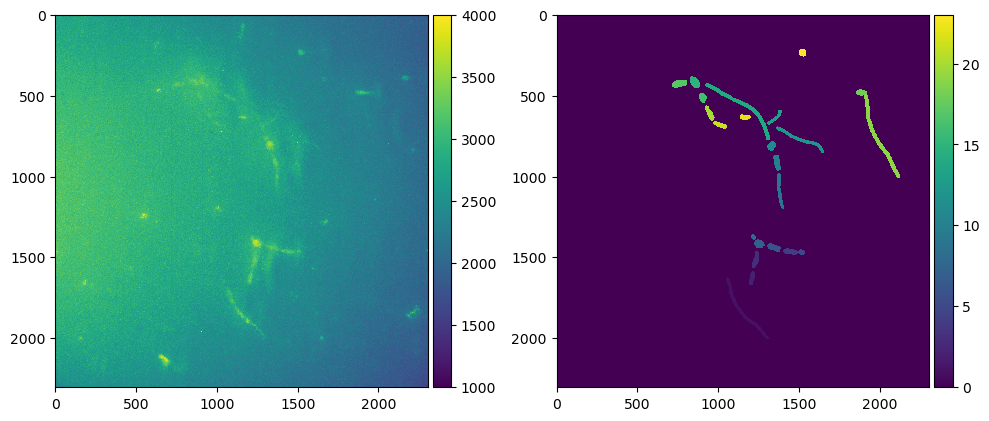

In [9]:
# inspect match
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
#io.imshow(img[11, ...], ax=ax[0]);
io.imshow(np.max(img, axis=0), ax=ax[0], vmin=1000, vmax=4000);
#io.imshow(img, ax=ax[0]);
io.imshow(mask, ax=ax[1]);
plt.show();

***

## 2.2 - Find in-focus layers on single image

### <span style="color:seagreen"> 2.2.1 - Find region with high cell density </span>

Let's determine the in-focus layers in our image. We will use the created cell mask to find a region in our image with a high density of cells. This area will then be used to define the in-focus layers, as defining the infocus scores for the entire z-stack is computationally too intensive.

selected_patch=(869, 1257)


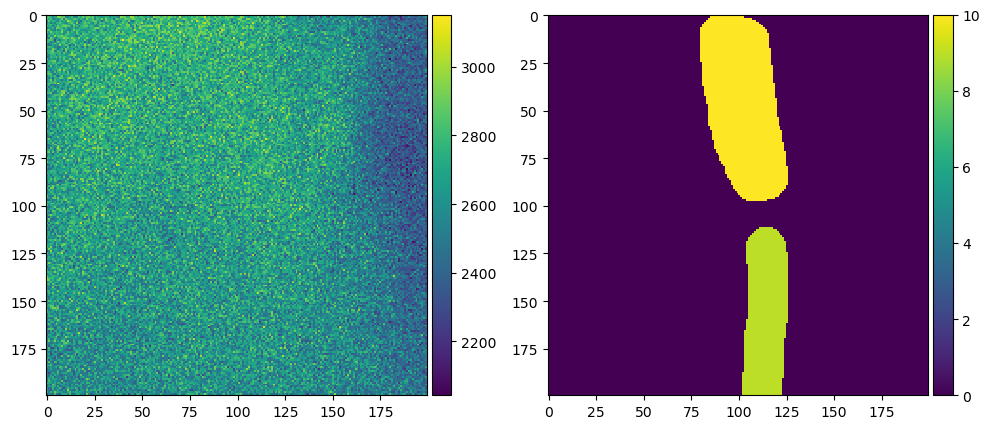

In [10]:
# find high density region
patch_size = (200, 200)
selected_patch = find_high_density_patch(mask)
print(f"{selected_patch=}")

mask_patch = mask[
             selected_patch[0]:selected_patch[0] + patch_size[0],
             selected_patch[1]:selected_patch[1] + patch_size[1]
             ]

img_patch = img[:,
            selected_patch[0]:selected_patch[0] + patch_size[0],
            selected_patch[1]:selected_patch[1] + patch_size[1]
            ]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(img_patch[0, ...], ax=ax[0]);
io.imshow(mask_patch, ax=ax[1]);
plt.show();

### <span style="color:seagreen"> 2.2.2 - Define in-focus layers </span>

Next we will use Helmli-Scherer mean(https://www.semanticscholar.org/paper/Adaptive-shape-from-focus-with-an-error-estimation-Helmli-Scherer/8fce39108fad9311f4c0196fcdbaabc8463de27a) to calculate the in-focus scores of each z-layer within the cropped area.

C:\Users\roana\anaconda3\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\Users\roana\AppData\Local\Temp\ipykernel_23052\3259823970.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


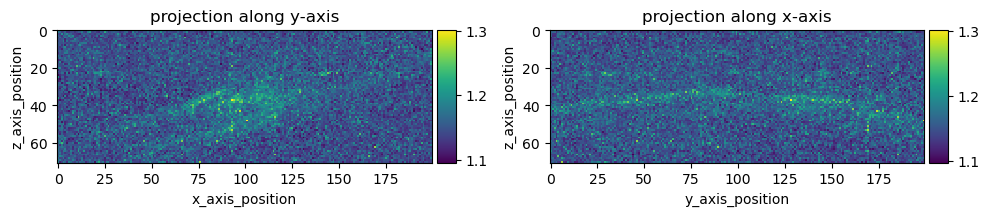

In [11]:
focus = compute_focus(img_patch)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(np.amax(focus, axis=1), ax=ax[0])
io.imshow(np.amax(focus, axis=2), ax=ax[1])

ax[0].set_xlabel('x_axis_position')
ax[0].set_ylabel('z_axis_position')
ax[0].set_title('projection along y-axis')

ax[1].set_xlabel('y_axis_position')
ax[1].set_ylabel('z_axis_position')
ax[1].set_title('projection along x-axis')

plt.tight_layout()
plt.show()


In [12]:
def show_boundaries(projected_focus, projected_focus_smoothed, ifx_1, ifx_2):
    # plotting of in-focus indices
    fig, axis = plt.subplots(ncols=3, figsize=(15, 5), facecolor='white')

    # plot max project focus scores
    sns.lineplot(x=range(len(projected_focus)), y=projected_focus, ax=axis[0])
    axis[0].set_xlabel('z-layer')
    axis[0].set_ylabel('score')
    axis[0].set_title('in-focus scores per z-layer')

    # plot smoothed focus scores
    sns.lineplot(x=range(len(projected_focus_smoothed)), y=projected_focus_smoothed, ax=axis[1])
    axis[1].set_xlabel('z-layer')
    axis[1].set_ylabel('score')
    axis[1].set_title('smoothed in-focus scores per z-layer')

    # plot projected focus image
    axis[2].imshow(np.amax(focus, axis=1))
    axis[2].set_title('y-max projection of the in-focus scores')

    # add indices of inflection point to plots
    axis[0].axvspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[0].axvspan(ifx_2 - 0.1, ifx_2, color='r')

    axis[1].axvspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[1].axvspan(ifx_2 - 0.1, ifx_2, color='r')

    axis[2].axhspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[2].axhspan(ifx_2 - 0.1, ifx_2, color='r')

    return fig


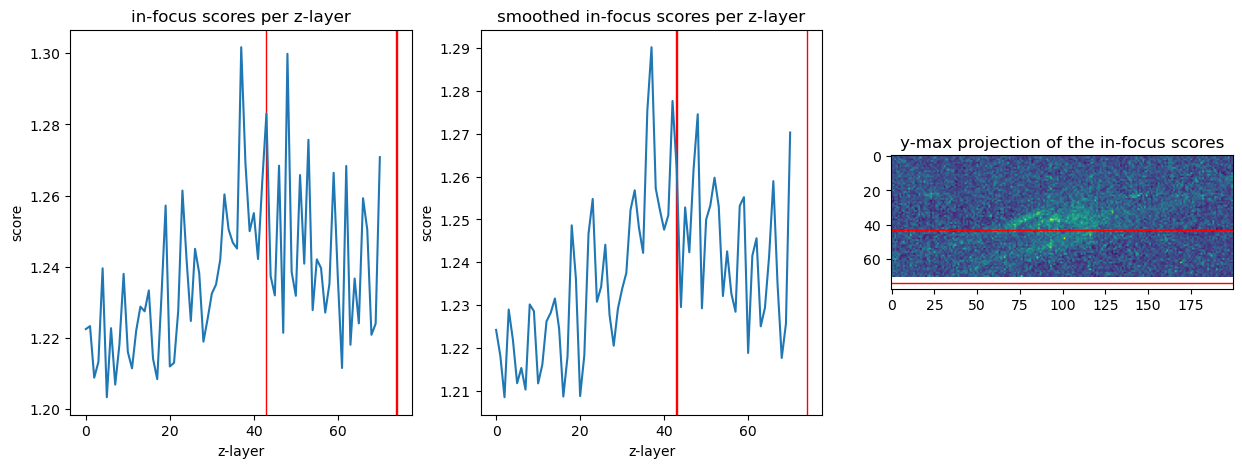

In [13]:
# max project the y,x scores to get a single focus score for each layer 
projected_focus = np.max(focus, axis=(1, 2))

# smoothing function
projected_focus_smoothed = savgol_filter(projected_focus, 4, 2, 0)
ifx_1, ifx_2 = find_in_focus_indices(projected_focus_smoothed, adjustment_bottom=5, adjustment_top=5)

fig = show_boundaries(projected_focus, projected_focus_smoothed, ifx_1, ifx_2)
plt.show()

In [14]:
ifx_1, ifx_2

#you can set range here:

ifx_1 = 20 
#ifx_2 =

***

## 2.3 - Spot detection on filtered images

### <span style="color:seagreen"> 2.3.1 - Detect spots in a guassian filtered image </span>

First we will perform background subtraction on your image. Next we will perform spot detection using a Laplacian of Gaussian filter (LoG). The set parameters often work well but can be adjusted if necessary.

In [15]:
scale = (200, 65, 65) # scale of a voxel's zyx dimensions in nanometer 
spot_radius = (1000, 170, 170) # expected size of spots in nanometer

# if detection threshold set to none, threshold is detected automatically
# Usually 5 or 6, but play around and check in napari if there's a good overlap with detected and actual spots.
detection_threshold = 2

In [16]:
viewer = napari.Viewer()

# here we add our image to the napari viewer, whilst also converting the pixel size to the nm scale
viewer.add_image(img, name='RNA channel', colormap='magenta', scale=scale)

# perform background filtering on your image. Adjust filtering parameters if necessary
filt_RNAs = remove_background_gaussian(img, sigma=(0.75, 2.3, 2.3))
viewer.add_image(filt_RNAs, name='filt RNA channel', scale=scale)

<Image layer 'filt RNA channel' at 0x10b51c53910>

In [17]:
if ifx_1<0:
    ifx_1=0

# select in-focus layers
sel_filt_RNAs = filt_RNAs[ifx_1:ifx_2, ...]

# perform spot detection
spots, threshold = detect_spots(
    sel_filt_RNAs,
    threshold=detection_threshold,
    voxel_size=scale,
    spot_radius=spot_radius,
    return_threshold=True)
print(f'This threshold was used : {threshold}')

# adjust spots coordinates
spots[:, 0] += ifx_1



This threshold was used : 2


In [18]:
# remove misdetection in adjustable out-focus layer
fspots = spots[spots[:, 0] > ifx_1 + 2]

# add detected spots to the viewer 
viewer.add_points(fspots, name='spots filt RNA channel', scale=scale, size=.5, symbol='ring')

<Points layer 'spots filt RNA channel' at 0x10b50a26590>

### <span style="color:seagreen"> 2.3.2 - Visualize and evaluate spot detection</span>

Let's check whether all spots were detected in the our image stack by projecting both spots and raw data to a single image layer.

In [19]:
viewer=napari.Viewer()

zproject = np.amax(img[ifx_1:ifx_2, ...], axis=0)

# add the z-projected image layer to the viewer
viewer.add_image(zproject, name='RNA channel', colormap='magenta', contrast_limits=[2000, 8000])

# combine all the spots into one layer and check if the number of spots matches the fluorescence image
viewer.add_points(fspots[:, 1:], size=20, symbol='ring', opacity=0.1)


<Points layer 'Points' at 0x10b919fdd90>

### <span style="color:seagreen"> 2.3.3 - Save spot data</span>

In [118]:
save_path = f'../data/spider_1_CLB2_HWP1_24HR/Spots/CET111_CLB21Q670_SC_24hr_05_spots_thr{threshold}.npy'

# uncomment to run:
np.save(save_path, fspots)

***

# Batch spot detection

Perform spot detection for all images in our dataset. Remember to adjust the parameters if necessary. Especially, the spot detection threshold, leave this parameter at None to let BigFISH determine this threshold automatically. The data is saved in the Spots folder in each condition + RNA combination.  This step has already been performed, uncomment the last line to do batch detection and overwrite the saved data.

In [23]:
# paths
root_dir = 'E:/Code/smFISH/data/Chip_9_24hr_CLB2_HWP1'
#root_dir = '../data/Chip_7' # directory for example data.

# parameters - adjust if necessary
scale = (200, 65, 65)
spot_radius = (1000, 170, 170)
sigma=(0.75, 2.3, 2.3)
patch_size = (200, 200)
detection_threshold = 6 # set to None for automatic determination by bigFISH

In [24]:
experiments = group_experiments(root_dir)

print('I found the following experiments:')
print(experiments.keys())
print('select applicable experiments')

print(root_dir)

I found the following experiments:
dict_keys(['CET111_CLB2Q670_SC', 'CET111_HWP1Q610_SC'])
select applicable experiments
E:/Code/smFISH/data/Chip_9_24hr_CLB2_HWP1


In [25]:
current_experiment = "CET111_HWP1Q610_SC"
experiments_to_process = [current_experiment]
print(current_experiment)
if "HWP1" in current_experiment:
    fluorophore = "CY3"
elif "CLB2" in current_experiment:
    fluorophore = "CY5"
elif "EFG1" in current_experiment:
    fluorophore = "CY5"
else:
    print("Couldnt establish fluorophore")



for identifier in experiments_to_process:
    replicates = experiments[identifier]
    
    for replicate, paths, in replicates.items():
        print(f'processing {identifier=}, {replicate=}')
        data = load_data(paths)
        
        process = True
        # check if all files required for this step have been loaded
        for entry in ['cell_mask', fluorophore]:
            if data.get(entry) is None:
                print(f'{identifier=}, {replicate=}, {entry=} could not be found')
                print(f'skipping {identifier=}, {replicate=}!')
                process=False
        
        if process:
            RNAs = data.get(fluorophore)            
            mask = data.get('cell_mask')
            
            selected_patch = find_high_density_patch(mask, patch_size=patch_size)
            
            img_patch = RNAs[:,
                selected_patch[0]:selected_patch[0] + patch_size[0],
                selected_patch[1]:selected_patch[1] + patch_size[1]
            ]

            focus = compute_focus(img_patch)
            projected_focus = np.max(focus, axis=(1, 2))

            projected_focus_smoothed = savgol_filter(projected_focus, 30, 2, 0)
            ifx_1, ifx_2 = find_in_focus_indices(projected_focus_smoothed)
            if ifx_1<0:
                ifx_1=0

            RNAs_filtered = remove_background_gaussian(RNAs, sigma=sigma)
            
            spots, threshold = detect_spots(
                RNAs_filtered[ifx_1:ifx_2, ...],
                threshold=detection_threshold,
                voxel_size=scale,
                spot_radius=spot_radius,
                return_threshold=True
            )
            
            # restore z-level
            spots[:,0] = spots[:,0] + ifx_1

            # adjustalbe out-of focus filtering
            spots = spots[spots[:,0]>ifx_1 + 2]
            
            save_name = f"{root_dir}/Spots/{paths['output_name']}_spots_thr{detection_threshold}.npy"

            # uncomment to save spots
            np.save(save_name, spots)
            print('done')
            
        print(10*'-')

CET111_HWP1Q610_SC
processing identifier='CET111_HWP1Q610_SC', replicate=3
done
----------
processing identifier='CET111_HWP1Q610_SC', replicate=5
done
----------
processing identifier='CET111_HWP1Q610_SC', replicate=6
done
----------
processing identifier='CET111_HWP1Q610_SC', replicate=7
done
----------
